In [95]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py

# mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('/home/aussing/sty.mplstyle')



In [96]:
UNITMASS = 1e10
LITTLEH = 0.6688
UNIT_LENGTH_FOR_PLOTS = 'Mpc'
npart_min = 100
npart_star_min = 1

In [97]:
def get_sim_data(sim_directory,n_file):
    snap_fname     = f'/snapshot_{str(n_file).zfill(3)}.hdf5'
    snap_directory = sim_directory + snap_fname
    snap_data     = h5py.File(snap_directory, 'r')
    
    # haloinfo_fname     = f'/fof_tab_{str(i_file).zfill(3)}.hdf5'
    haloinfo_fname     = f'/fof_subhalo_tab_{str(n_file).zfill(3)}.hdf5'
    haloinfo_directory = sim_directory + haloinfo_fname
    haloinfo_data = h5py.File(haloinfo_directory, 'r')

    z = np.round(snap_data['Header'].attrs['Redshift'],2)
    return snap_data, haloinfo_data, z

In [98]:
def set_plot_len(data):
    if UNIT_LENGTH_FOR_PLOTS in ['Mpc','mpc']:
        data = data/3.085678e24
    elif UNIT_LENGTH_FOR_PLOTS in ['Kpc','kpc']:
        data = data/3.085678e21
    elif UNIT_LENGTH_FOR_PLOTS == 'pc':
        data = data/3.085678e18
    else:
        print("What units do you want?????!!! AARRHH")
        raise TypeError
    return data


In [99]:
def get_unit_len(snapshot):
    unit_length = snapshot["Parameters"].attrs['UnitLength_in_cm']
    
    return unit_length

In [100]:
def subhalo_data(sim_directory,i_file):
    snap_data, haloinfo_data, z = get_sim_data(sim_directory,i_file)
    z = np.round(z,2)
    print(z)
    unit_len = get_unit_len(snap_data)

    halo_pos   = np.array(haloinfo_data['Group']['GroupPos'], dtype=np.float64) / LITTLEH
    halo_mass  = np.array(haloinfo_data['Group']['GroupMass'], dtype=np.float64) * UNITMASS / LITTLEH
    halo_M200c = np.array(haloinfo_data['Group']['Group_M_Crit200'], dtype=np.float64) * UNITMASS / LITTLEH
    halo_masstypes = np.array(haloinfo_data['Group']['GroupMassType'], dtype=np.float64) * UNITMASS / LITTLEH
    R200c = np.array(haloinfo_data['Group']['Group_R_Crit200'], dtype=np.float64) / LITTLEH

    mass_mask = np.argsort(halo_M200c)[::-1]
    halo_mainID = np.where(halo_masstypes[mass_mask,5] == 0)[0][0]

    print(f"Redshift = {np.round(z,2)}")
    print(f"main halo ID = {mass_mask[halo_mainID]}")
    print(f"Main halo pos = {halo_pos[mass_mask[halo_mainID],:]}")
    print(f'M_200c = {np.round(halo_M200c[mass_mask[halo_mainID]]/1e10,3)}e10 h^-1 Msun')
    print(f"R_200c = {np.round(set_plot_len(R200c[mass_mask[halo_mainID]]*unit_len),4)} {UNIT_LENGTH_FOR_PLOTS}")

    main_halo_only = True
    subhalo_halo_num = np.array(haloinfo_data['Subhalo']['SubhaloGroupNr'], dtype=np.float64)
    subhalo_rank       = np.array(haloinfo_data['Subhalo']['SubhaloRankInGr'], dtype=np.int32)

    subhalo_mass       = np.array(haloinfo_data['Subhalo']['SubhaloMass'],dtype=np.float64) * UNITMASS / LITTLEH
    subhalo_mass_type  = np.array(haloinfo_data['Subhalo']['SubhaloMassType'],dtype=np.float64) * UNITMASS / LITTLEH
    subhalo_len        = np.array(haloinfo_data['Subhalo']['SubhaloLen'],dtype=np.int32)
    subhalo_len_type   = np.array(haloinfo_data['Subhalo']['SubhaloLenType'],dtype=np.int32)
    subhalo_pos        = np.array(haloinfo_data['Subhalo']['SubhaloPos'], dtype=np.float64) / LITTLEH 

    main_halo_subhalos = np.where(subhalo_halo_num==[mass_mask[halo_mainID]])

    subhalo_mass       = subhalo_mass[main_halo_subhalos][subhalo_rank[main_halo_subhalos]!=0] 
    subhalo_mass_type  = subhalo_mass_type[main_halo_subhalos][subhalo_rank[main_halo_subhalos]!=0]
    subhalo_len        = subhalo_len[main_halo_subhalos][subhalo_rank[main_halo_subhalos]!=0]
    subhalo_len_type   = subhalo_len_type[main_halo_subhalos][subhalo_rank[main_halo_subhalos]!=0]

    subhalo_pos = np.array(haloinfo_data['Subhalo']['SubhaloPos'], dtype=np.float64) / LITTLEH 
    subhalo_pos = subhalo_pos[main_halo_subhalos][subhalo_rank[main_halo_subhalos]!=0]

    # subhalo_pos_dif = subhalo_pos - halo_pos[mass_mask[halo_mainID],:]
    # print(f"subhalo rank 0 - {subhalo_pos[0,:]}")
    # print(f"subhalo rank 1 - {subhalo_pos[1,:]}\n")

    subhalo_dist = []
    for i in range(len(subhalo_pos)):
        # print(positions[i])
        # print((positions-main_halo_pos)[i])
        subhalo_pos_dif = subhalo_pos[i] - halo_pos[mass_mask[halo_mainID],:]
        subhalo_dist.append(np.sqrt(subhalo_pos_dif[0]**2+subhalo_pos_dif[1]**2+subhalo_pos_dif[2]**2))

    subhalo_dist = np.array(subhalo_dist)
    mask_dists = (subhalo_dist>0.01) #& (subhalo_dist<set_plot_len(R200c[mass_mask[halo_mainID]]*unit_len))
    print(subhalo_dist[mask_dists])
    test = subhalo_dist[mask_dists]

    # dm_mass_cdm              = subhalo_mass_type[np.where(subhalo_len>npart_min)[0],1]
    # dm_mass_ordered_cdm      = np.argsort(dm_mass_cdm)[::-1]
    # dm_mas_cdm               = dm_mass_cdm[dm_mass_ordered_cdm][np.where(dm_mass_cdm[dm_mass_ordered_cdm]>0)[0]]
    # dm_mass_sum_cdm          = np.cumsum(np.ones(dm_mas_cdm.shape[0]))
    
    # mask_total_len = np.where(subhalo_len>=npart_min)[0]
    # mask_stel_len = np.where(subhalo_len_type[:,4]>=npart_star_min)[0]
    
    # mask = mask_total_len[np.isin(mask_total_len,mask_stel_len)]

    mask = (subhalo_len>=npart_min) & (subhalo_len_type[:,4]>=npart_star_min) & (subhalo_dist>0.005)  #& (subhalo_dist<set_plot_len(R200c[mass_mask[halo_mainID]]*unit_len))

    # print(mask)
    star_mass              = subhalo_mass_type[mask,4]
    star_mass_ordered      = np.argsort(star_mass)[::-1]
    star_mass              = star_mass[star_mass_ordered][np.where(star_mass[star_mass_ordered]>0)[0]]
    star_mass_sum          = np.cumsum(np.ones(star_mass.shape[0]))
    

    return star_mass, star_mass_sum, z

In [101]:
def AHF_data(ahf_halos):
    ahf_cols = []
    with open(ahf_halos) as ahf_f:
        aux_ahf_cols = ahf_f.readline()[1:].split('\t')
        for el in aux_ahf_cols:
            ahf_cols.append(el.rpartition('(')[0])
    ahf_cols = ahf_cols[:-1]
    ahf_cols = np.array(ahf_cols)

    ahf_dat = pd.read_table(ahf_halos,delim_whitespace=True,names=ahf_cols,header=0)

    # print(np.sort(ahf_cols[:]))
    
    mainhaloes = ahf_dat[(ahf_dat['hostHalo']==0) & (ahf_dat['fMhires']==1) & (ahf_dat['npart']>npart_min)].sort_values('Mhalo',ascending=False)

    halo_mass_ahf = mainhaloes['Mhalo'] / LITTLEH
    main_halo_pos = np.array((mainhaloes['Xc'].iloc[0] ,mainhaloes['Yc'].iloc[0] / 1,mainhaloes['Zc'].iloc[0] / 1)) / 1e3 / LITTLEH
    print(f"AHF halo mass = {mainhaloes['Mhalo'].iloc[0] / LITTLEH / UNITMASS }e10 Msun")
    print(f"AHF halo radius = {mainhaloes['Rhalo'].iloc[0] / LITTLEH / 1e3} Mpc")
    print(f"AHF halo pos = {main_halo_pos}")

    subhaloes = ahf_dat[(ahf_dat['hostHalo']!=0) & (ahf_dat['fMhires']==1) & (ahf_dat['npart']>npart_min)]
    MH_subhaloes = subhaloes[subhaloes['hostHalo']==mainhaloes['ID'].iloc[0]]
    xpos = MH_subhaloes['Xc'] / 1e3 / LITTLEH   # [MH_subhaloes['M_star']>0]
    ypos = MH_subhaloes['Yc'] / 1e3 / LITTLEH   # [MH_subhaloes['M_star']>0]
    zpos = MH_subhaloes['Zc'] / 1e3 / LITTLEH   # [MH_subhaloes['M_star']>0]
    positions = np.column_stack((xpos,ypos,zpos)) 
    subhalo_dist = []
    for i in range(len(positions)):
        # print(positions[i])
        # print((positions-main_halo_pos)[i])
        subhalo_pos_dif = (positions-main_halo_pos)[i]
        subhalo_dist.append(np.sqrt(subhalo_pos_dif[0]**2+subhalo_pos_dif[1]**2+subhalo_pos_dif[2]**2))
        # print()

    
    subhalo_dist = np.array(subhalo_dist)
    # print(subhalo_dist[subhalo_dist>0.01])
    # print(MH_subhaloes['M_star'][MH_subhaloes['M_star']>0][subhalo_dist<0.01])
    
    mask_ahf = (MH_subhaloes['M_star']>0) & (MH_subhaloes['n_star']>=npart_star_min) & (subhalo_dist>0.005) #& (subhalo_dist<mainhaloes['Rhalo'].iloc[0] / LITTLEH / 1e3)

    
    MH_subhaloes_sorted = np.sort(MH_subhaloes['M_star'][mask_ahf])[::-1] / LITTLEH

    subhalo_cummass_func_ahf = np.cumsum(np.ones(len(MH_subhaloes_sorted)))
    
    return MH_subhaloes_sorted, subhalo_cummass_func_ahf

In [102]:
ahf_halos_cdm_005 = '/fred/oz217/aussing/N2048_L65_sd46371/cdm/zoom/output/sn_005/ahf/AHF.N2048_L65_sd46371-sn_005.snap_026.z0.000.AHF_halos'
ahf_halos_cdm_010 = '/fred/oz217/aussing/N2048_L65_sd46371/cdm/zoom/output/sn_010/ahf/AHF.N2048_L65_sd46371-sn_010.snap_026.z0.000.AHF_halos'

ahf_halos_wdm_005 = '/fred/oz217/aussing/N2048_L65_sd46371/wdm_3.5/zoom/output/sn_005/ahf/AHF.N2048_L65_sd46371-sn_005.snap_026.z0.000.AHF_halos'
ahf_halos_wdm_010 = '/fred/oz217/aussing/N2048_L65_sd46371/wdm_3.5/zoom/output/sn_010/ahf/AHF.N2048_L65_sd46371-sn_010.snap_026.z0.000.AHF_halos'

MH_subhaloes_cdm_005,subhalo_cummass_func_ahf_cdm_005 = AHF_data(ahf_halos_cdm_005)
MH_subhaloes_cdm_010,subhalo_cummass_func_ahf_cdm_010 = AHF_data(ahf_halos_cdm_010)

MH_subhaloes_wdm_005,subhalo_cummass_func_ahf_wdm_005 = AHF_data(ahf_halos_wdm_005)
MH_subhaloes_wdm_010,subhalo_cummass_func_ahf_wdm_010 = AHF_data(ahf_halos_wdm_010)

AHF halo mass = 186.67314593301438e10 Msun
AHF halo radius = 0.2618271531100479 Mpc
AHF halo pos = [41.07441743 53.54832521 48.17760792]
AHF halo mass = 186.0316985645933e10 Msun
AHF halo radius = 0.2615281100478469 Mpc
AHF halo pos = [41.07533118 53.54719528 48.17843711]
AHF halo mass = 170.50986842105263e10 Msun
AHF halo radius = 0.254037081339713 Mpc
AHF halo pos = [41.09594878 53.55014884 48.18828317]
AHF halo mass = 170.50837320574166e10 Msun
AHF halo radius = 0.254037081339713 Mpc
AHF halo pos = [41.09902442 53.54897771 48.18800882]


In [103]:
sim_directory_cdm_005 = '/fred/oz217/aussing/N2048_L65_sd46371/cdm/zoom/output/sn_005/'
sim_directory_cdm_010 = '/fred/oz217/aussing/N2048_L65_sd46371/cdm/zoom/output/sn_010/'

sim_directory_wdm_005 = '/fred/oz217/aussing/N2048_L65_sd46371/wdm_3.5/zoom/output/sn_005/'
sim_directory_wdm_010 = '/fred/oz217/aussing/N2048_L65_sd46371/wdm_3.5/zoom/output/sn_010/'
i_file = 26
star_mass_cdm_005, star_mass_sum_cdm_005, z = subhalo_data(sim_directory_cdm_005,i_file)
star_mass_cdm_010, star_mass_sum_cdm_010, z = subhalo_data(sim_directory_cdm_010,i_file)

star_mass_wdm_005, star_mass_sum_wdm_005, z = subhalo_data(sim_directory_wdm_005,i_file)
star_mass_wdm_010, star_mass_sum_wdm_010, z = subhalo_data(sim_directory_wdm_010,i_file)

0.0
Redshift = 0.0
main halo ID = 0
Main halo pos = [41.07431362 53.54839649 48.17743621]
M_200c = 186.675e10 h^-1 Msun
R_200c = 0.2618 Mpc
[0.17303986 0.20832581 0.2451957  0.16875217 0.28541484 0.22095071
 0.41616298 0.28769569 0.20653237 0.35962139 0.16075445 0.17231375
 0.38539225 0.35590471 0.2008959  0.28303231 0.27918049 0.21888227
 0.24656283 0.20886628 0.1438237  0.26573574 0.14162506 0.0577531
 0.37025959 0.25708616 0.3440449  0.22206338 0.10825209 0.15195909
 0.19899834 0.23169576 0.32867287 0.26966063 0.2514478  0.33689204
 0.14856417 0.1897781  0.14743382 0.18178882 0.12929511 0.19061586
 0.19329255 0.04640371 0.08676201 0.19552976 0.10945823 0.31379044
 0.1313975  0.09898846 0.25012758 0.2375912  0.31658207 0.27835389
 0.45702697 0.20908341 0.13967061 0.23053945 0.1337667  0.32197905
 0.29305099 0.1610459  0.21961785 0.03123578 0.21286684 0.15788214
 0.15093383 0.27649806 0.18345999 0.31095569 0.14985317 0.23421772
 0.21325467 0.08814525 0.15912539 0.23299117 0.2977868  0

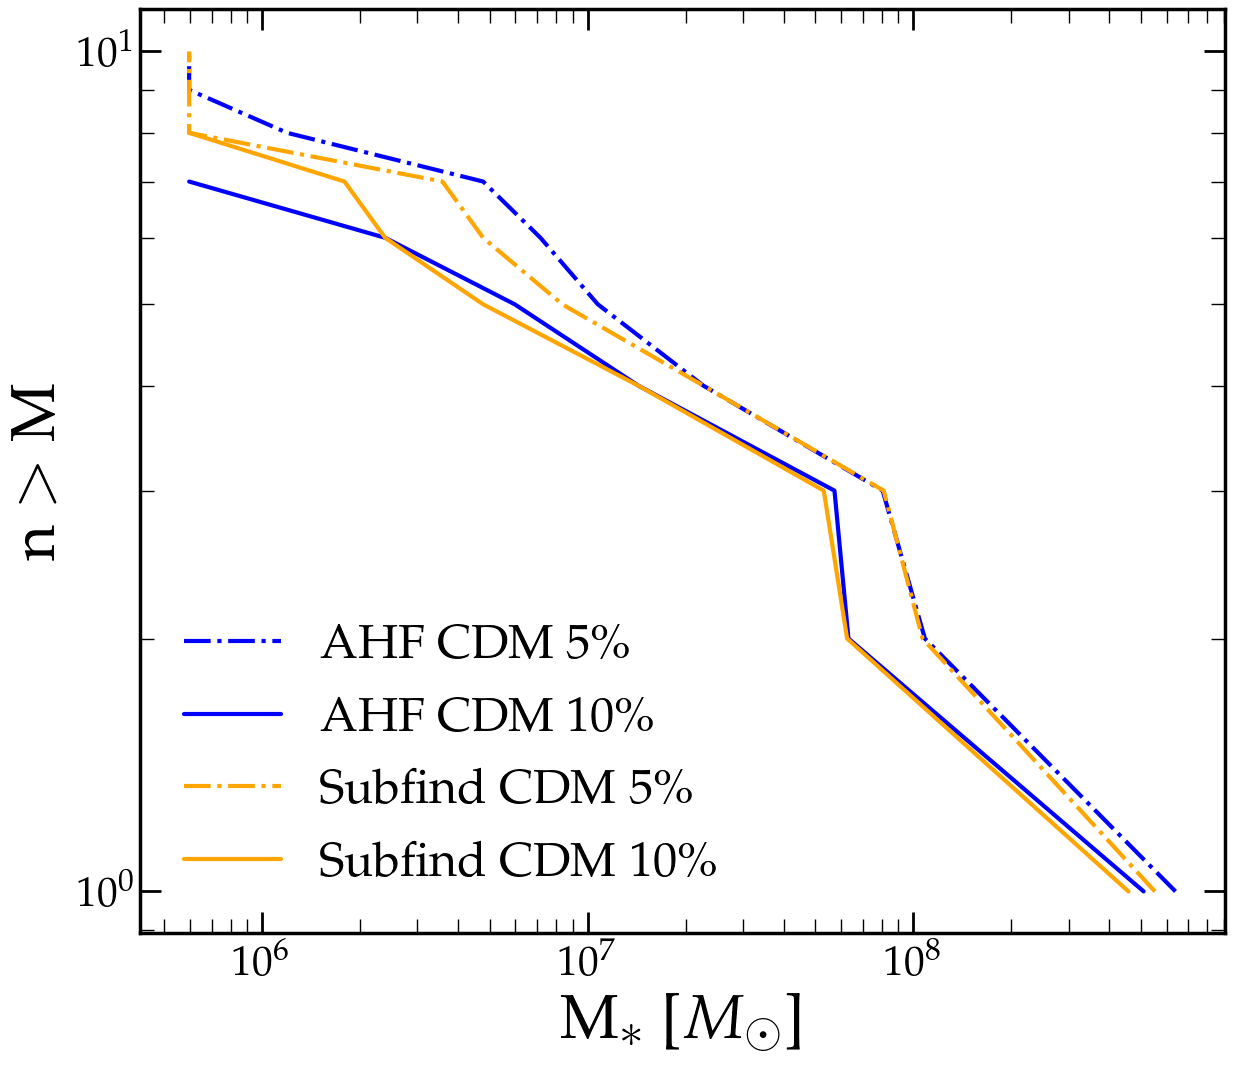

In [104]:
# figure = plt.figure(figsize=(6,4))
figure = plt.figure()
plt.plot(MH_subhaloes_cdm_005,subhalo_cummass_func_ahf_cdm_005,color='blue',label='AHF CDM 5\%',linestyle='-.')
plt.plot(MH_subhaloes_cdm_010,subhalo_cummass_func_ahf_cdm_010,color='blue',label='AHF CDM 10\%')
plt.plot(star_mass_cdm_005, star_mass_sum_cdm_005,color='orange',label=f'Subfind CDM 5\%',linestyle='-.')
plt.plot(star_mass_cdm_010, star_mass_sum_cdm_010,color='orange',label=f'Subfind CDM 10\%')

# z = np.round(z,2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'M$_{*}$ [$M_{\odot}$]')
plt.ylabel(r'n $>$ M ')
# plt.title(f'CDM satellite Galaxy Population at z={np.round(z,2)}, Min particles = {npart_min}')
plt.legend(loc='lower left')

# plt.savefig(f'{folder}/cumulative_shmf_z_{z}.png',dpi=400,bbox_inches='tight')
# plt.savefig(f'./plots/cdm_subfind_ahf.png',dpi=400,bbox_inches='tight')
plt.savefig(f'./cdm_subfind_ahf.png',dpi=400,bbox_inches='tight')
plt.show()

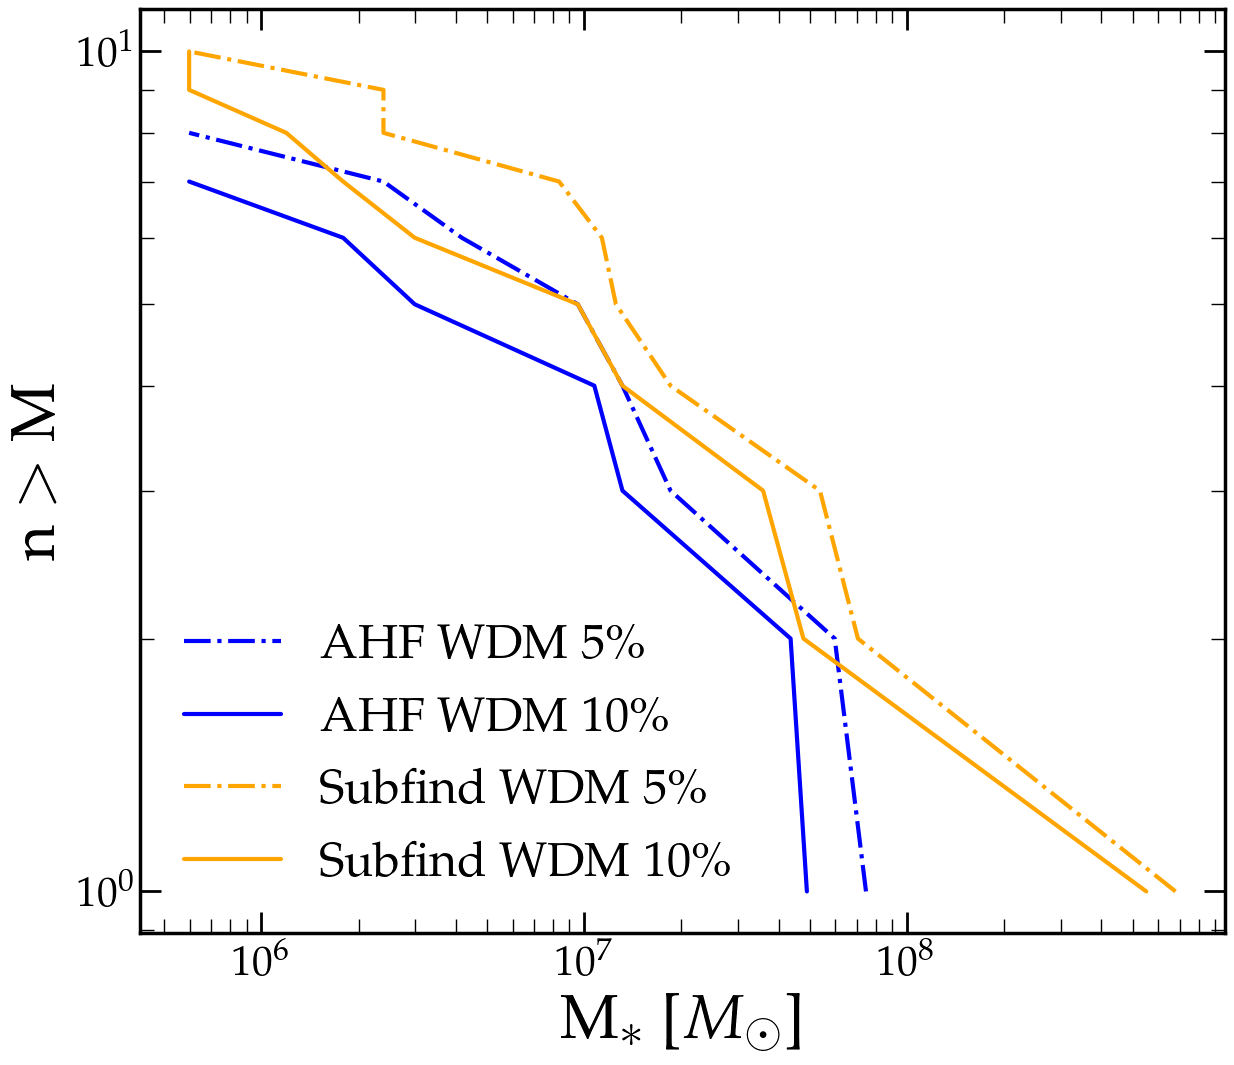

In [105]:
# figure = plt.figure(figsize=(6,4))
figure = plt.figure()
plt.plot(MH_subhaloes_wdm_005,subhalo_cummass_func_ahf_wdm_005,color='blue',label='AHF WDM 5\%',linestyle='-.')
plt.plot(MH_subhaloes_wdm_010,subhalo_cummass_func_ahf_wdm_010,color='blue',label='AHF WDM 10\%')

plt.plot(star_mass_wdm_005, star_mass_sum_wdm_005,color='orange',label=f'Subfind WDM 5\%',linestyle='-.')
plt.plot(star_mass_wdm_010, star_mass_sum_wdm_010,color='orange',label=f'Subfind WDM 10\%')

# plt.plot(MH_subhaloes_cdm_005,subhalo_cummass_func_ahf_cdm_005,color='blue',alpha=0.3,linestyle='-.')
# plt.plot(MH_subhaloes_cdm_010,subhalo_cummass_func_ahf_cdm_010,color='orange',alpha=0.3,linestyle='-.')
# plt.plot(star_mass_cdm_005, star_mass_sum_cdm_005,color='blue',alpha=0.3)
# plt.plot(star_mass_cdm_010, star_mass_sum_cdm_010,color='orange',alpha=0.3)

# z = np.round(z,2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'M$_{*}$ [$M_{\odot}$]')
plt.ylabel(r'n $>$ M ')
# plt.title(f'WDM satellite Galaxy Population at z={np.round(z,2)}, Min particles = {npart_min}')
plt.legend(loc='lower left')

# plt.savefig(f'{folder}/cumulative_shmf_z_{z}.png',dpi=400,bbox_inches='tight')
# plt.savefig(f'./plots/wdm_subfind_ahf.png',dpi=400,bbox_inches='tight')
plt.savefig(f'./wdm_subfind_ahf.png',dpi=400,bbox_inches='tight')
plt.show()

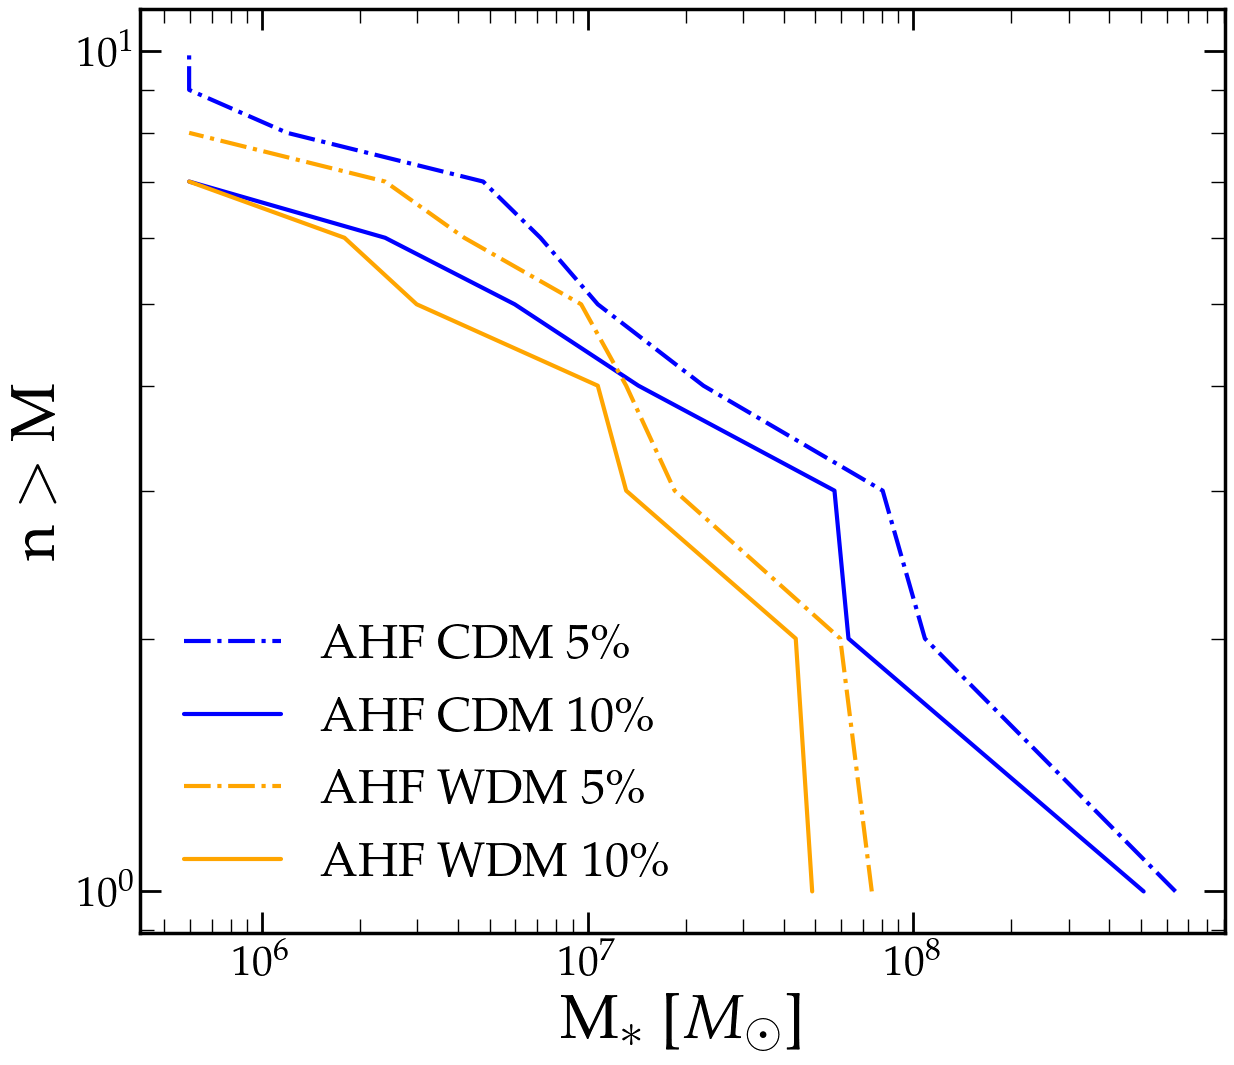

In [106]:
# figure = plt.figure(figsize=(6,4))
figure = plt.figure()

plt.plot(MH_subhaloes_cdm_005,subhalo_cummass_func_ahf_cdm_005,color='blue',label='AHF CDM 5\%',linestyle='-.')
plt.plot(MH_subhaloes_cdm_010,subhalo_cummass_func_ahf_cdm_010,color='blue',label='AHF CDM 10\%')

plt.plot(MH_subhaloes_wdm_005,subhalo_cummass_func_ahf_wdm_005,color='orange',label='AHF WDM 5\%',linestyle='-.')
plt.plot(MH_subhaloes_wdm_010,subhalo_cummass_func_ahf_wdm_010,color='orange',label='AHF WDM 10\%')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'M$_{*}$ [$M_{\odot}$]')
plt.ylabel(r'n $>$ M ')
# plt.title(f'WDM satellite Galaxy Population at z={np.round(z,2)}, Min particles = {npart_min}')
plt.legend(loc='lower left')

# plt.savefig(f'./plots/ahf_comb.png',dpi=400,bbox_inches='tight')
plt.savefig(f'./ahf_comb.png',dpi=400,bbox_inches='tight')
plt.show()

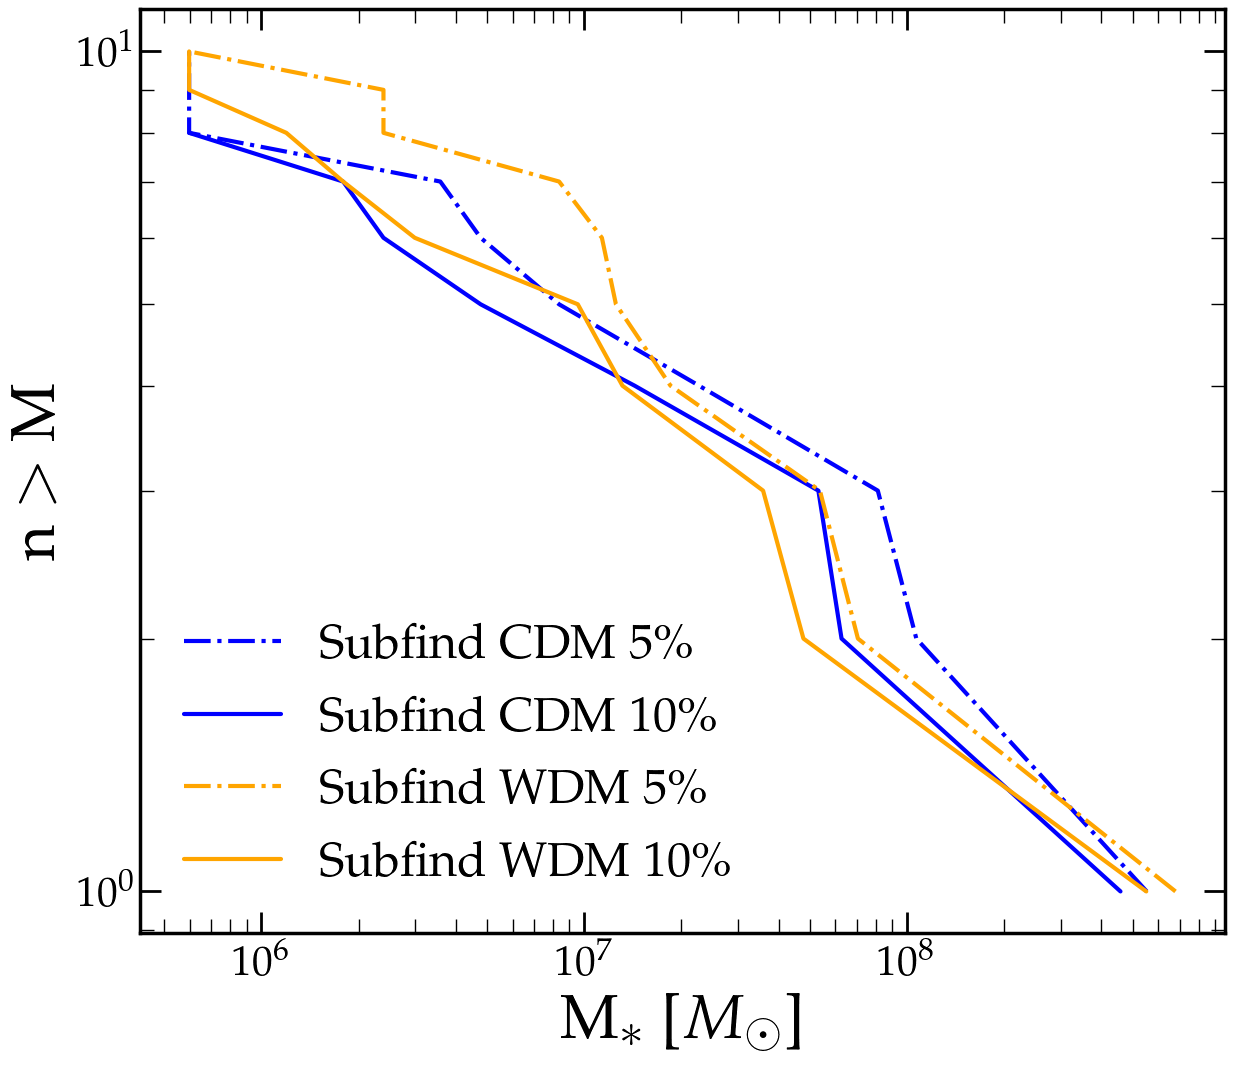

In [107]:
# figure = plt.figure(figsize=(6,4))
figure = plt.figure()
plt.plot(star_mass_cdm_005, star_mass_sum_cdm_005,color='blue',label=f'Subfind CDM 5\%',linestyle='-.')
plt.plot(star_mass_cdm_010, star_mass_sum_cdm_010,color='blue',label=f'Subfind CDM 10\%')


plt.plot(star_mass_wdm_005, star_mass_sum_wdm_005,color='orange',label=f'Subfind WDM 5\%',linestyle='-.')
plt.plot(star_mass_wdm_010, star_mass_sum_wdm_010,color='orange',label=f'Subfind WDM 10\%')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'M$_{*}$ [$M_{\odot}$]')
plt.ylabel(r'n $>$ M ')
# plt.title(f'WDM satellite Galaxy Population at z={np.round(z,2)}, Min particles = {npart_min}')
plt.legend(loc='lower left')

# plt.savefig(f'./plots/subfind_comb.png',dpi=400,bbox_inches='tight')
plt.savefig(f'./subfind_comb.png',dpi=400,bbox_inches='tight')
plt.show()